In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os

In [2]:
ee.Initialize()

In [3]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)


##FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [4]:
#L5
L5_low = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_20020108')))
L5_mid = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19991202')))
L5_high = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_20011020')))

#L7
L7_low = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_016038_20020508')))
L7_mid = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_017038_20020616')))
L7_high = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_016038_20020201')))

#L8
L8_low = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016038_20201211')))
L8_mid = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016038_20220320')))
L8_high = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_017038_20201116')))

#L9
L9_low = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20211229')))
L9_mid = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20220130')))
L9_high = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20220303')))

In [5]:
#Directory
out_dir = os.path.join("F:/Flats imagery")

In [6]:
gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

image = L9_low
filename = os.path.join(out_dir, 'l9low.tif')

image = image.clip(flux_ga).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

In [7]:
import geopandas as gpd
import rasterio


In [8]:
l5low_path = 'F:/Flats imagery/l5low.flats.tif'
l5mid_path = 'F:/Flats imagery/l5mid.flats.tif'
l5high_path = 'F:/Flats imagery/l5high.flats.tif'


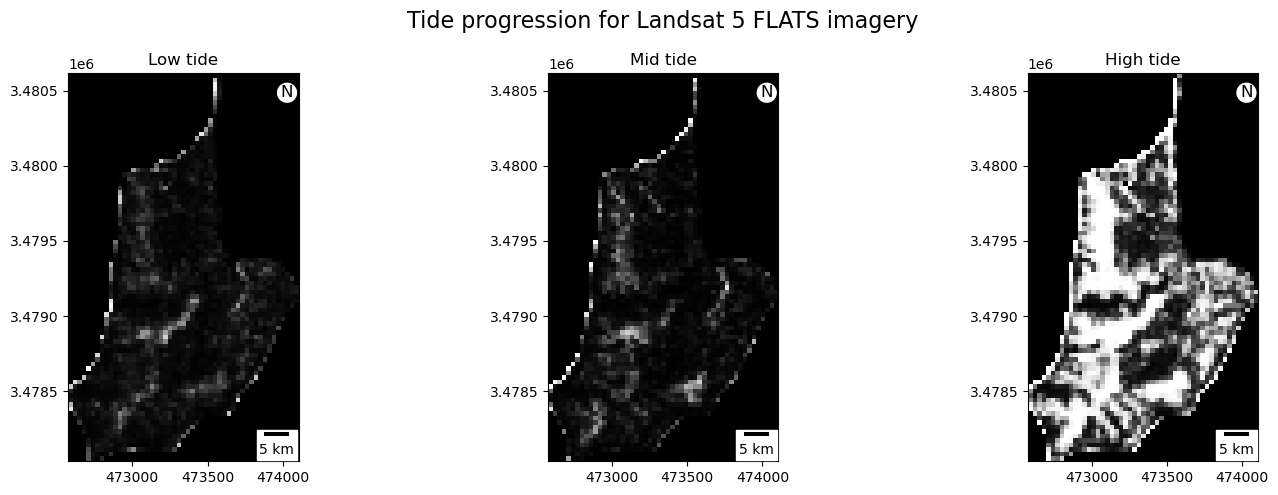

In [50]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import numpy as np

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 0.75  # Adjust the gamma value as needed
        data = data ** gamma
        
         # Create a custom grayscale colormap
        cmap = colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap)

        # Add a scale bar
        scale_bar = ScaleBar(src.res[0], location='lower right')
        ax.add_artist(scale_bar)

        # Add a north arrow (you may need to customize the arrow symbol)
        ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle='circle,pad=0.2', fc='white'))

        # Set subplot title
        ax.set_title(title)
        

# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define titles for each subplot
titles = ['Low tide', 'Mid tide', 'High tide']

# Plot each GeoTIFF image with its corresponding title
plot_geotiff_with_scale_and_north_arrow(l5low_path, axs[0], titles[0])
plot_geotiff_with_scale_and_north_arrow(l5mid_path, axs[1], titles[1])
plot_geotiff_with_scale_and_north_arrow(l5high_path, axs[2], titles[2])

# Add a title for the entire figure (optional)
plt.suptitle('Tide progression for Landsat 5 FLATS imagery', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [51]:
l8low_path = 'F:/Flats imagery/l8low.flats.tif'
l8mid_path = 'F:/Flats imagery/l8mid.flats.tif'
l8high_path = 'F:/Flats imagery/l8high.flats.tif'

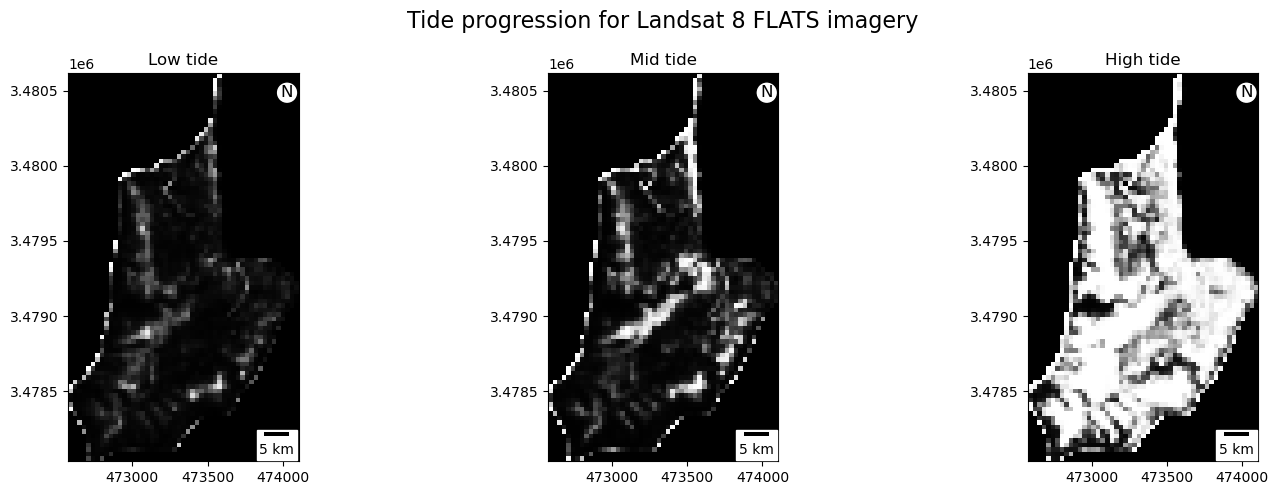

In [57]:
def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 0.75  # Adjust the gamma value as needed
        data = data ** gamma
        
         # Create a custom grayscale colormap
        cmap = colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap)

        # Add a scale bar
        scale_bar = ScaleBar(src.res[0], location='lower right')
        ax.add_artist(scale_bar)

        # Add a north arrow (you may need to customize the arrow symbol)
        ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle='circle,pad=0.2', fc='white'))

        # Set subplot title
        ax.set_title(title)
        

# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define titles for each subplot
titles = ['Low tide', 'Mid tide', 'High tide']

# Plot each GeoTIFF image with its corresponding title
plot_geotiff_with_scale_and_north_arrow(l8low_path, axs[0], titles[0])
plot_geotiff_with_scale_and_north_arrow(l8mid_path, axs[1], titles[1])
plot_geotiff_with_scale_and_north_arrow(l8high_path, axs[2], titles[2])

# Add a title for the entire figure (optional)
plt.suptitle('Tide progression for Landsat 8 FLATS imagery', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

